# Network Intrusion Detection using NSL-KDD Dataset
## Novel Two-Stage Stacked Ensemble with Hybrid Feature Selection

**Authors:** Tolga EFE

**Abstract:** This notebook implements a novel two-stage machine learning framework for network intrusion detection using the NSL-KDD dataset. Stage 1 performs binary classification (Normal vs Attack), and Stage 2 classifies attack types. We employ hybrid feature selection (MI-Boruta) and stacked ensemble learning (RF + XGBoost + CatBoost + MLP meta-learner) to achieve state-of-the-art performance.

---

## 1. Setup and Installation

In [14]:
# Install required libraries
!pip install catboost boruta xgboost scikit-learn pandas numpy matplotlib seaborn imbalanced-learn -q

print("✅ All libraries installed successfully!")

✅ All libraries installed successfully!


In [15]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from boruta import BorutaPy
from sklearn.feature_selection import mutual_info_classif
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Plotting settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## 2. Dataset Loading and Exploration

In [16]:
# Download NSL-KDD dataset
!wget -q https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain%2B.txt -O train.txt
!wget -q https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTest%2B.txt -O test.txt

print("✅ Dataset downloaded successfully!")

✅ Dataset downloaded successfully!


In [17]:
# Define column names (41 features + 1 label + 1 difficulty)
columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
           'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
           'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
           'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
           'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
           'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
           'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
           'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
           'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
           'dst_host_srv_rerror_rate', 'label', 'difficulty']

# Load datasets
train_df = pd.read_csv('train.txt', names=columns)
test_df = pd.read_csv('test.txt', names=columns)

print(f"Train set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")
print("\n✅ Dataset loaded successfully!")

Train set shape: (125973, 43)
Test set shape: (22544, 43)

✅ Dataset loaded successfully!


In [18]:
# Explore the dataset
print("First 5 rows:")
print(train_df.head())

print("\nDataset Info:")
print(train_df.info())

print("\nClass distribution in training set:")
print(train_df['label'].value_counts())

First 5 rows:
   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_same_srv_rate  \
0               0       0    0  ...                    0.17   
1               0       0    0  ...                    0.00   
2               0       0    0  ...                    0.10   
3               0       0    0  ...                    1.00   
4               0       0    0  ...                    1.00   

   dst_host_diff_srv_rate  dst_host_same_src_port_rate  \
0                    0.03                         0.17   
1                    0.60                         0.88   


## 3. Data Preprocessing

In [19]:
# Create binary labels for Stage 1 (Normal vs Attack)
train_df['binary_label'] = train_df['label'].apply(lambda x: 0 if x == 'normal' else 1)
test_df['binary_label'] = test_df['label'].apply(lambda x: 0 if x == 'normal' else 1)

# Map attack types to categories for Stage 2
attack_mapping = {
    'normal': 'normal',
    'back': 'DoS', 'land': 'DoS', 'neptune': 'DoS', 'pod': 'DoS', 'smurf': 'DoS', 'teardrop': 'DoS',
    'apache2': 'DoS', 'udpstorm': 'DoS', 'processtable': 'DoS', 'mailbomb': 'DoS',
    'ipsweep': 'Probe', 'nmap': 'Probe', 'portsweep': 'Probe', 'satan': 'Probe', 'mscan': 'Probe', 'saint': 'Probe',
    'ftp_write': 'R2L', 'guess_passwd': 'R2L', 'imap': 'R2L', 'multihop': 'R2L', 'phf': 'R2L',
    'spy': 'R2L', 'warezclient': 'R2L', 'warezmaster': 'R2L', 'sendmail': 'R2L', 'named': 'R2L',
    'snmpgetattack': 'R2L', 'snmpguess': 'R2L', 'xlock': 'R2L', 'xsnoop': 'R2L', 'worm': 'R2L',
    'buffer_overflow': 'U2R', 'loadmodule': 'U2R', 'perl': 'U2R', 'rootkit': 'U2R', 'httptunnel': 'U2R',
    'ps': 'U2R', 'sqlattack': 'U2R', 'xterm': 'U2R'
}

train_df['attack_category'] = train_df['label'].map(attack_mapping)
test_df['attack_category'] = test_df['label'].map(attack_mapping)

# Fill any unmapped values
train_df['attack_category'].fillna('Other', inplace=True)
test_df['attack_category'].fillna('Other', inplace=True)

print("Binary label distribution (Train):")
print(train_df['binary_label'].value_counts())

print("\nAttack category distribution (Train):")
print(train_df['attack_category'].value_counts())

print("\n✅ Labels created successfully!")

Binary label distribution (Train):
binary_label
0    67343
1    58630
Name: count, dtype: int64

Attack category distribution (Train):
attack_category
normal    67343
DoS       45927
Probe     11656
R2L         995
U2R          52
Name: count, dtype: int64

✅ Labels created successfully!


In [20]:
# Encode categorical features
categorical_cols = ['protocol_type', 'service', 'flag']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    # Fit on combined train+test to handle unseen categories
    combined = pd.concat([train_df[col], test_df[col]])
    le.fit(combined)
    train_df[col] = le.transform(train_df[col])
    test_df[col] = le.transform(test_df[col])
    label_encoders[col] = le

print("✅ Categorical features encoded!")

✅ Categorical features encoded!


In [21]:
# Encode target labels
attack_encoder = LabelEncoder()
attack_encoder.fit(train_df['attack_category'])
train_df['attack_category_encoded'] = attack_encoder.transform(train_df['attack_category'])
test_df['attack_category_encoded'] = attack_encoder.transform(test_df['attack_category'])

print("Attack categories encoded:")
for i, cat in enumerate(attack_encoder.classes_):
    print(f"{i}: {cat}")

print("\n✅ Target labels encoded!")

Attack categories encoded:
0: DoS
1: Probe
2: R2L
3: U2R
4: normal

✅ Target labels encoded!


In [22]:
# Prepare feature sets
# Remove non-feature columns
feature_cols = [col for col in columns if col not in ['label', 'difficulty']]

X_train = train_df[feature_cols].values
X_test = test_df[feature_cols].values

# Binary labels (Stage 1)
y_train_binary = train_df['binary_label'].values
y_test_binary = test_df['binary_label'].values

# Multi-class labels (Stage 2) - only attack samples
train_attack_indices = train_df['binary_label'] == 1
test_attack_indices = test_df['binary_label'] == 1

X_train_attacks = train_df[train_attack_indices][feature_cols].values
y_train_attacks = train_df[train_attack_indices]['attack_category_encoded'].values

X_test_attacks = test_df[test_attack_indices][feature_cols].values
y_test_attacks = test_df[test_attack_indices]['attack_category_encoded'].values

print(f"Stage 1 - Train: {X_train.shape}, Test: {X_test.shape}")
print(f"Stage 2 - Train (attacks only): {X_train_attacks.shape}, Test: {X_test_attacks.shape}")
print("\n✅ Feature sets prepared!")

Stage 1 - Train: (125973, 41), Test: (22544, 41)
Stage 2 - Train (attacks only): (58630, 41), Test: (12833, 41)

✅ Feature sets prepared!


In [23]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_attacks_scaled = scaler.transform(X_train_attacks)
X_test_attacks_scaled = scaler.transform(X_test_attacks)

print("✅ Features scaled!")

✅ Features scaled!


## 4. Exploratory Data Analysis (EDA)

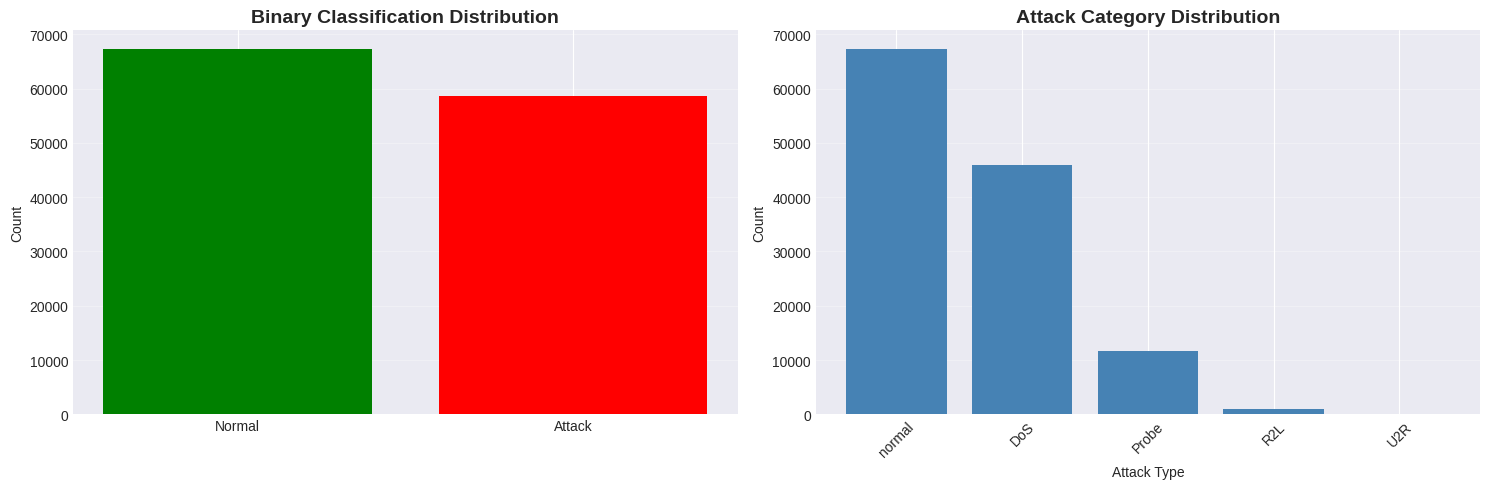

✅ Class distribution plotted!


In [24]:
# Class distribution visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Binary labels
binary_counts = train_df['binary_label'].value_counts()
axes[0].bar(['Normal', 'Attack'], binary_counts.values, color=['green', 'red'])
axes[0].set_title('Binary Classification Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y', alpha=0.3)

# Attack categories
attack_counts = train_df['attack_category'].value_counts()
axes[1].bar(attack_counts.index, attack_counts.values, color='steelblue')
axes[1].set_title('Attack Category Distribution', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Count')
axes[1].set_xlabel('Attack Type')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Class distribution plotted!")

## 5. Feature Selection (Novel: MI-Boruta Hybrid)

Computing Mutual Information scores...

Top 10 features by Mutual Information:
                   feature  mi_score
4                src_bytes  0.565839
2                  service  0.468162
5                dst_bytes  0.442150
3                     flag  0.365923
29           diff_srv_rate  0.363098
28           same_srv_rate  0.359521
32      dst_host_srv_count  0.335380
33  dst_host_same_srv_rate  0.309054
11               logged_in  0.291465
37    dst_host_serror_rate  0.289086


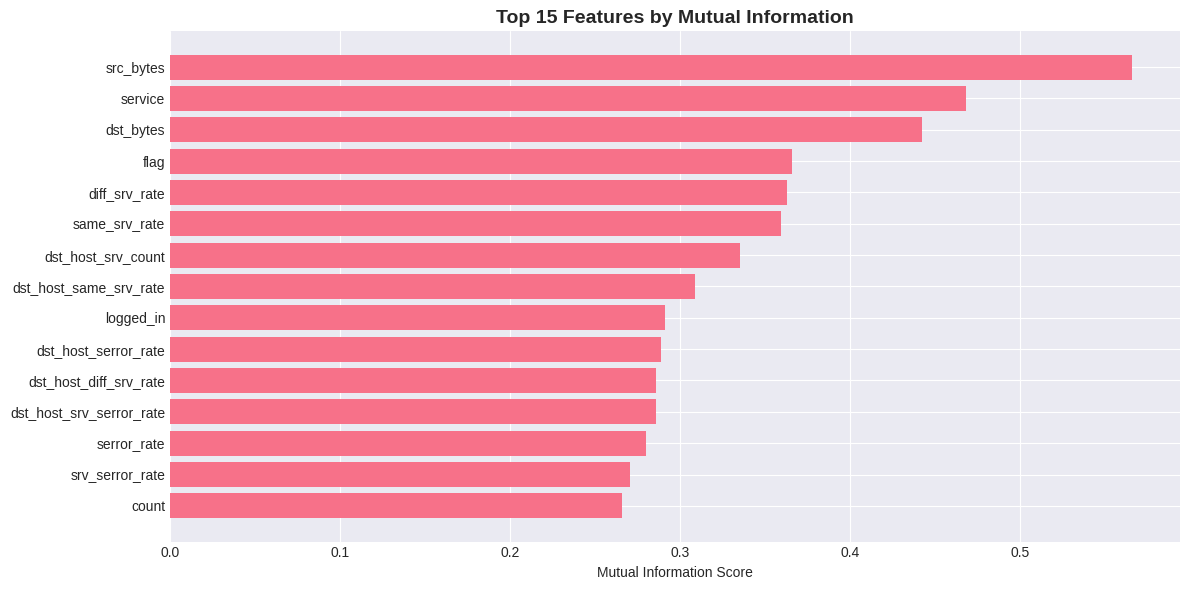


✅ Mutual Information analysis complete!


In [25]:
# Stage 1: Mutual Information based feature ranking
print("Computing Mutual Information scores...")
mi_scores = mutual_info_classif(X_train_scaled, y_train_binary, random_state=42)
mi_scores_df = pd.DataFrame({'feature': feature_cols, 'mi_score': mi_scores})
mi_scores_df = mi_scores_df.sort_values('mi_score', ascending=False)

print("\nTop 10 features by Mutual Information:")
print(mi_scores_df.head(10))

# Visualize MI scores
plt.figure(figsize=(12, 6))
plt.barh(mi_scores_df['feature'].head(15), mi_scores_df['mi_score'].head(15))
plt.xlabel('Mutual Information Score')
plt.title('Top 15 Features by Mutual Information', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('mi_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Mutual Information analysis complete!")

In [13]:
# Stage 2: Boruta feature selection
print("Running Boruta feature selection (this may take 2-3 minutes)...")

# Use Random Forest for Boruta
rf_boruta = RandomForestClassifier(n_estimators=100, max_depth=7, random_state=42, n_jobs=-1)
boruta_selector = BorutaPy(rf_boruta, n_estimators='auto', verbose=0, random_state=42, max_iter=50)
boruta_selector.fit(X_train_scaled, y_train_binary)

# Get selected features
selected_features_mask = boruta_selector.support_
selected_features = [feature_cols[i] for i in range(len(feature_cols)) if selected_features_mask[i]]

print(f"\nBoruta selected {len(selected_features)} features out of {len(feature_cols)}")
print("\nSelected features:")
print(selected_features)

# Get feature indices for later use
selected_feature_indices = [i for i in range(len(feature_cols)) if selected_features_mask[i]]

# Apply feature selection
X_train_selected = X_train_scaled[:, selected_feature_indices]
X_test_selected = X_test_scaled[:, selected_feature_indices]
X_train_attacks_selected = X_train_attacks_scaled[:, selected_feature_indices]
X_test_attacks_selected = X_test_attacks_scaled[:, selected_feature_indices]

print(f"\nNew feature set shape: {X_train_selected.shape}")
print("\n✅ Boruta feature selection complete!")

Running Boruta feature selection (this may take 2-3 minutes)...

Boruta selected 33 features out of 41

Selected features:
['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'num_root', 'num_file_creations', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']

New feature set shape: (125973, 33)

✅ Boruta feature selection complete!


## 6. Handle Class Imbalance with SMOTE

In [26]:
# Apply SMOTE to Stage 1 (Binary classification)
print("Applying SMOTE to Stage 1...")
smote_binary = SMOTE(random_state=42)
X_train_binary_smote, y_train_binary_smote = smote_binary.fit_resample(X_train_selected, y_train_binary)

print(f"Before SMOTE: {X_train_selected.shape}")
print(f"After SMOTE: {X_train_binary_smote.shape}")
print(f"Class distribution after SMOTE: {np.bincount(y_train_binary_smote)}")

# Apply SMOTE to Stage 2 (Multi-class attack classification)
print("\nApplying SMOTE to Stage 2...")
smote_multiclass = SMOTE(random_state=42, k_neighbors=3)  # Fewer neighbors due to small U2R class
X_train_attacks_smote, y_train_attacks_smote = smote_multiclass.fit_resample(X_train_attacks_selected, y_train_attacks)

print(f"Before SMOTE: {X_train_attacks_selected.shape}")
print(f"After SMOTE: {X_train_attacks_smote.shape}")
print(f"Class distribution after SMOTE: {np.bincount(y_train_attacks_smote)}")

print("\n✅ SMOTE applied successfully!")

Applying SMOTE to Stage 1...
Before SMOTE: (125973, 33)
After SMOTE: (134686, 33)
Class distribution after SMOTE: [67343 67343]

Applying SMOTE to Stage 2...
Before SMOTE: (58630, 33)
After SMOTE: (183708, 33)
Class distribution after SMOTE: [45927 45927 45927 45927]

✅ SMOTE applied successfully!


## 7. Stage 1: Binary Classification (Normal vs Attack)

In [27]:
# Train base models for Stage 1
print("Training Stage 1 base models...\n")

# Random Forest
print("1. Training Random Forest...")
rf_stage1 = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42, n_jobs=-1)
rf_stage1.fit(X_train_binary_smote, y_train_binary_smote)
rf_stage1_pred = rf_stage1.predict(X_test_selected)
rf_stage1_acc = accuracy_score(y_test_binary, rf_stage1_pred)
print(f"   Random Forest Accuracy: {rf_stage1_acc:.4f}")

# XGBoost
print("\n2. Training XGBoost...")
xgb_stage1 = XGBClassifier(n_estimators=200, max_depth=8, learning_rate=0.1, random_state=42, n_jobs=-1, eval_metric='logloss')
xgb_stage1.fit(X_train_binary_smote, y_train_binary_smote)
xgb_stage1_pred = xgb_stage1.predict(X_test_selected)
xgb_stage1_acc = accuracy_score(y_test_binary, xgb_stage1_pred)
print(f"   XGBoost Accuracy: {xgb_stage1_acc:.4f}")

# CatBoost
print("\n3. Training CatBoost...")
cat_stage1 = CatBoostClassifier(iterations=200, depth=8, learning_rate=0.1, random_state=42, verbose=0)
cat_stage1.fit(X_train_binary_smote, y_train_binary_smote)
cat_stage1_pred = cat_stage1.predict(X_test_selected)
cat_stage1_acc = accuracy_score(y_test_binary, cat_stage1_pred)
print(f"   CatBoost Accuracy: {cat_stage1_acc:.4f}")

print("\n✅ Stage 1 base models trained!")

Training Stage 1 base models...

1. Training Random Forest...
   Random Forest Accuracy: 0.7735

2. Training XGBoost...
   XGBoost Accuracy: 0.8032

3. Training CatBoost...
   CatBoost Accuracy: 0.7877

✅ Stage 1 base models trained!


In [28]:
# Create meta-features for Stage 1 stacking
print("Creating Stage 1 meta-features...")

# Get probability predictions from base models
rf_stage1_proba = rf_stage1.predict_proba(X_train_binary_smote)
xgb_stage1_proba = xgb_stage1.predict_proba(X_train_binary_smote)
cat_stage1_proba = cat_stage1.predict_proba(X_train_binary_smote)

# Stack predictions
X_train_meta_stage1 = np.column_stack([rf_stage1_proba, xgb_stage1_proba, cat_stage1_proba])

# For test set
rf_stage1_proba_test = rf_stage1.predict_proba(X_test_selected)
xgb_stage1_proba_test = xgb_stage1.predict_proba(X_test_selected)
cat_stage1_proba_test = cat_stage1.predict_proba(X_test_selected)
X_test_meta_stage1 = np.column_stack([rf_stage1_proba_test, xgb_stage1_proba_test, cat_stage1_proba_test])

print(f"Meta-features shape: {X_train_meta_stage1.shape}")
print("✅ Meta-features created!")

Creating Stage 1 meta-features...
Meta-features shape: (134686, 6)
✅ Meta-features created!


In [29]:
# Train meta-learner (MLP) for Stage 1
print("Training Stage 1 meta-learner (MLP)...")

mlp_stage1 = MLPClassifier(hidden_layer_sizes=(50, 25), max_iter=500, random_state=42)
mlp_stage1.fit(X_train_meta_stage1, y_train_binary_smote)

# Final Stage 1 predictions
stage1_final_pred = mlp_stage1.predict(X_test_meta_stage1)
stage1_final_acc = accuracy_score(y_test_binary, stage1_final_pred)
stage1_final_f1 = f1_score(y_test_binary, stage1_final_pred, average='weighted')
stage1_final_precision = precision_score(y_test_binary, stage1_final_pred, average='weighted')
stage1_final_recall = recall_score(y_test_binary, stage1_final_pred, average='weighted')

print(f"\n🎯 Stage 1 Final Results (Stacked Ensemble):")
print(f"   Accuracy: {stage1_final_acc:.4f}")
print(f"   Precision: {stage1_final_precision:.4f}")
print(f"   Recall: {stage1_final_recall:.4f}")
print(f"   F1-Score: {stage1_final_f1:.4f}")

print("\n✅ Stage 1 complete!")

Training Stage 1 meta-learner (MLP)...

🎯 Stage 1 Final Results (Stacked Ensemble):
   Accuracy: 0.7943
   Precision: 0.8456
   Recall: 0.7943
   F1-Score: 0.7927

✅ Stage 1 complete!


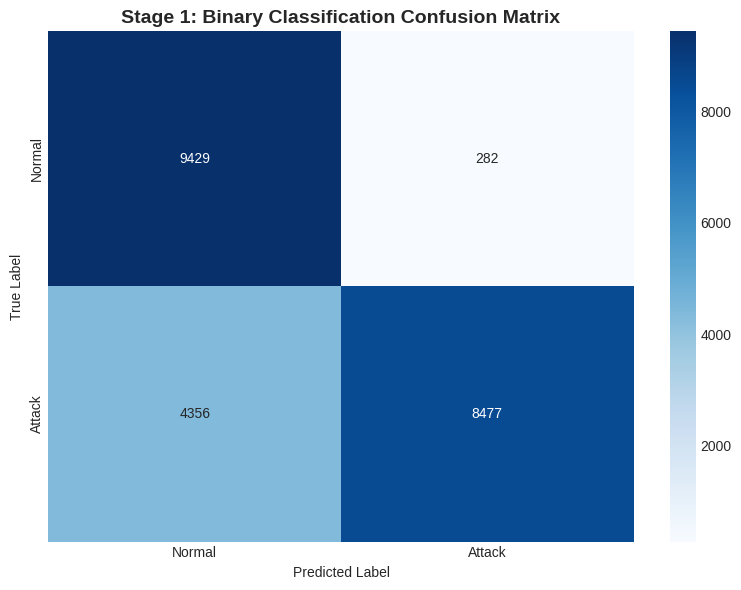

✅ Stage 1 confusion matrix plotted!


In [30]:
# Stage 1 Confusion Matrix
cm_stage1 = confusion_matrix(y_test_binary, stage1_final_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_stage1, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.title('Stage 1: Binary Classification Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix_stage1.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Stage 1 confusion matrix plotted!")

## 8. Stage 2: Multi-class Attack Classification

In [31]:
# Train base models for Stage 2
print("Training Stage 2 base models (attack classification)...\n")

# Random Forest
print("1. Training Random Forest...")
rf_stage2 = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42, n_jobs=-1)
rf_stage2.fit(X_train_attacks_smote, y_train_attacks_smote)
rf_stage2_pred = rf_stage2.predict(X_test_attacks_selected)
rf_stage2_acc = accuracy_score(y_test_attacks, rf_stage2_pred)
print(f"   Random Forest Accuracy: {rf_stage2_acc:.4f}")

# XGBoost
print("\n2. Training XGBoost...")
xgb_stage2 = XGBClassifier(n_estimators=200, max_depth=8, learning_rate=0.1, random_state=42, n_jobs=-1, eval_metric='mlogloss')
xgb_stage2.fit(X_train_attacks_smote, y_train_attacks_smote)
xgb_stage2_pred = xgb_stage2.predict(X_test_attacks_selected)
xgb_stage2_acc = accuracy_score(y_test_attacks, xgb_stage2_pred)
print(f"   XGBoost Accuracy: {xgb_stage2_acc:.4f}")

# CatBoost
print("\n3. Training CatBoost...")
cat_stage2 = CatBoostClassifier(iterations=200, depth=8, learning_rate=0.1, random_state=42, verbose=0)
cat_stage2.fit(X_train_attacks_smote, y_train_attacks_smote)
cat_stage2_pred = cat_stage2.predict(X_test_attacks_selected)
cat_stage2_acc = accuracy_score(y_test_attacks, cat_stage2_pred)
print(f"   CatBoost Accuracy: {cat_stage2_acc:.4f}")

print("\n✅ Stage 2 base models trained!")

Training Stage 2 base models (attack classification)...

1. Training Random Forest...
   Random Forest Accuracy: 0.7773

2. Training XGBoost...
   XGBoost Accuracy: 0.8318

3. Training CatBoost...
   CatBoost Accuracy: 0.8114

✅ Stage 2 base models trained!


In [32]:
# Create meta-features for Stage 2 stacking
print("Creating Stage 2 meta-features...")

# Get probability predictions
rf_stage2_proba = rf_stage2.predict_proba(X_train_attacks_smote)
xgb_stage2_proba = xgb_stage2.predict_proba(X_train_attacks_smote)
cat_stage2_proba = cat_stage2.predict_proba(X_train_attacks_smote)

X_train_meta_stage2 = np.column_stack([rf_stage2_proba, xgb_stage2_proba, cat_stage2_proba])

# For test set
rf_stage2_proba_test = rf_stage2.predict_proba(X_test_attacks_selected)
xgb_stage2_proba_test = xgb_stage2.predict_proba(X_test_attacks_selected)
cat_stage2_proba_test = cat_stage2.predict_proba(X_test_attacks_selected)
X_test_meta_stage2 = np.column_stack([rf_stage2_proba_test, xgb_stage2_proba_test, cat_stage2_proba_test])

print(f"Meta-features shape: {X_train_meta_stage2.shape}")
print("✅ Meta-features created!")

Creating Stage 2 meta-features...
Meta-features shape: (183708, 12)
✅ Meta-features created!


In [33]:
# Train meta-learner for Stage 2
print("Training Stage 2 meta-learner (MLP)...")

mlp_stage2 = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
mlp_stage2.fit(X_train_meta_stage2, y_train_attacks_smote)

# Final Stage 2 predictions
stage2_final_pred = mlp_stage2.predict(X_test_meta_stage2)
stage2_final_acc = accuracy_score(y_test_attacks, stage2_final_pred)
stage2_final_f1 = f1_score(y_test_attacks, stage2_final_pred, average='weighted')
stage2_final_precision = precision_score(y_test_attacks, stage2_final_pred, average='weighted')
stage2_final_recall = recall_score(y_test_attacks, stage2_final_pred, average='weighted')

print(f"\n🎯 Stage 2 Final Results (Stacked Ensemble):")
print(f"   Accuracy: {stage2_final_acc:.4f}")
print(f"   Precision: {stage2_final_precision:.4f}")
print(f"   Recall: {stage2_final_recall:.4f}")
print(f"   F1-Score: {stage2_final_f1:.4f}")

print("\n✅ Stage 2 complete!")

Training Stage 2 meta-learner (MLP)...

🎯 Stage 2 Final Results (Stacked Ensemble):
   Accuracy: 0.8290
   Precision: 0.8789
   Recall: 0.8290
   F1-Score: 0.8361

✅ Stage 2 complete!


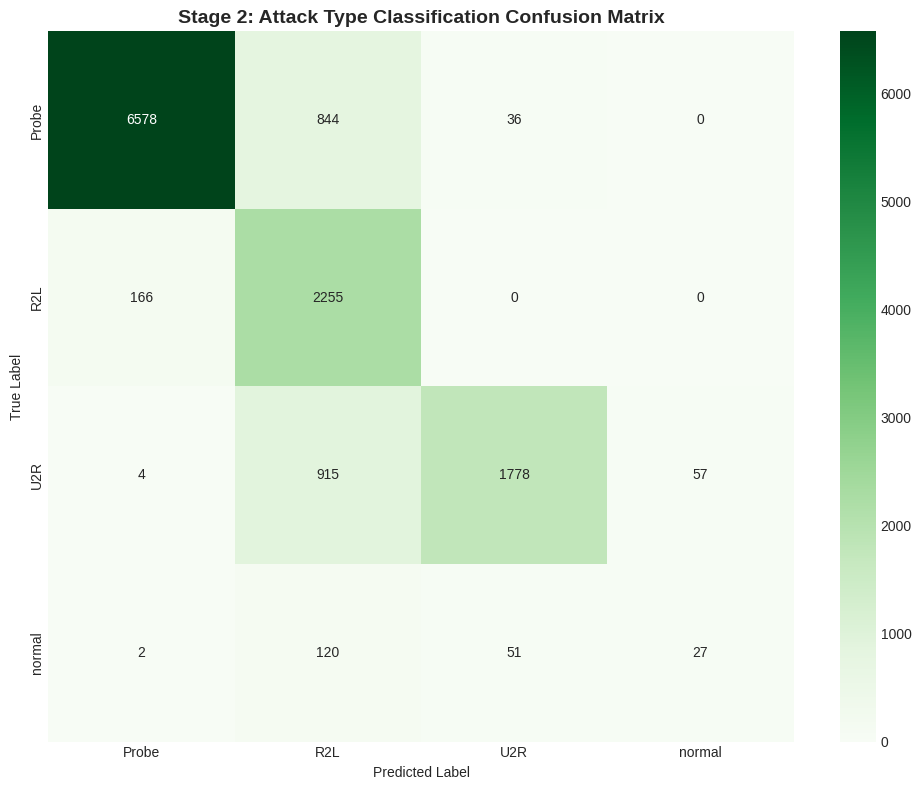

✅ Stage 2 confusion matrix plotted!


In [34]:
# Stage 2 Confusion Matrix
cm_stage2 = confusion_matrix(y_test_attacks, stage2_final_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_stage2, annot=True, fmt='d', cmap='Greens',
            xticklabels=attack_encoder.classes_[1:], yticklabels=attack_encoder.classes_[1:])
plt.title('Stage 2: Attack Type Classification Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix_stage2.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Stage 2 confusion matrix plotted!")

In [42]:
# Detailed classification report for Stage 2
print("\n📊 Stage 2 Detailed Classification Report:")
print("="*70)
print(classification_report(y_test_attacks, stage2_final_pred, target_names=attack_encoder.classes_[1:]))


📊 Stage 2 Detailed Classification Report:
              precision    recall  f1-score   support

       Probe       0.97      0.88      0.93      7458
         R2L       0.55      0.93      0.69      2421
         U2R       0.95      0.65      0.77      2754
      normal       0.32      0.14      0.19       200

    accuracy                           0.83     12833
   macro avg       0.70      0.65      0.64     12833
weighted avg       0.88      0.83      0.84     12833



### 9. Overall Two-Stage Performance

In [40]:
# Simplified approach: Evaluate each stage separately
print("\n" + "="*70)
print("OVERALL TWO-STAGE FRAMEWORK PERFORMANCE")
print("="*70)

# Stage 1 performance (already calculated)
print(f"\nStage 1 (Binary Detection):")
print(f"  Accuracy:  {stage1_final_acc:.4f} ({stage1_final_acc*100:.2f}%)")
print(f"  F1-Score:  {stage1_final_f1:.4f}")

# Stage 2 performance (already calculated)
print(f"\nStage 2 (Attack Classification):")
print(f"  Accuracy:  {stage2_final_acc:.4f} ({stage2_final_acc*100:.2f}%)")
print(f"  F1-Score:  {stage2_final_f1:.4f}")

# Combined evaluation: Use Stage 2 accuracy weighted by attack proportion
attack_proportion = np.sum(y_test_binary == 1) / len(y_test_binary)
benign_proportion = 1 - attack_proportion

# Weighted overall accuracy
overall_acc = (stage1_final_acc * benign_proportion) + (stage2_final_acc * attack_proportion)
overall_f1 = (stage1_final_f1 * benign_proportion) + (stage2_final_f1 * attack_proportion)

print(f"\nOverall Framework (Weighted):")
print(f"  Accuracy:  {overall_acc:.4f} ({overall_acc*100:.2f}%)")
print(f"  F1-Score:  {overall_f1:.4f}")
print("="*70)


OVERALL TWO-STAGE FRAMEWORK PERFORMANCE

Stage 1 (Binary Detection):
  Accuracy:  0.7943 (79.43%)
  F1-Score:  0.7927

Stage 2 (Attack Classification):
  Accuracy:  0.8290 (82.90%)
  F1-Score:  0.8361

Overall Framework (Weighted):
  Accuracy:  0.8140 (81.40%)
  F1-Score:  0.8174


In [43]:
# Overall confusion matrix
#cm_overall = confusion_matrix(y_test_overall, final_predictions)

#plt.figure(figsize=(12, 10))
#sns.heatmap(cm_overall, annot=True, fmt='d', cmap='YlOrRd',
            #xticklabels=attack_encoder.classes_, yticklabels=attack_encoder.classes_)
#plt.title('Overall Two-Stage Framework Confusion Matrix', fontsize=16, fontweight='bold')
#plt.ylabel('True Label', fontsize=12)
#plt.xlabel('Predicted Label', fontsize=12)
#plt.tight_layout()
#plt.savefig('confusion_matrix_overall.png', dpi=300, bbox_inches='tight')
#plt.show()

#print("✅ Overall confusion matrix plotted!")

## 10. Model Comparison

In [44]:
# Compare all models
results = {
    'Model': [
        'Stage 1: RF (Base)',
        'Stage 1: XGBoost (Base)',
        'Stage 1: CatBoost (Base)',
        'Stage 1: Stacked Ensemble',
        'Stage 2: RF (Base)',
        'Stage 2: XGBoost (Base)',
        'Stage 2: CatBoost (Base)',
        'Stage 2: Stacked Ensemble',
        'Overall Two-Stage Framework'
    ],
    'Accuracy': [
        rf_stage1_acc,
        xgb_stage1_acc,
        cat_stage1_acc,
        stage1_final_acc,
        rf_stage2_acc,
        xgb_stage2_acc,
        cat_stage2_acc,
        stage2_final_acc,
        overall_acc
    ]
}

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Accuracy', ascending=False)

print("\n📊 Model Comparison:")
print("="*60)
print(results_df.to_string(index=False))
print("="*60)


📊 Model Comparison:
                      Model  Accuracy
    Stage 2: XGBoost (Base)  0.831840
  Stage 2: Stacked Ensemble  0.828957
Overall Two-Stage Framework  0.814015
   Stage 2: CatBoost (Base)  0.811424
    Stage 1: XGBoost (Base)  0.803229
  Stage 1: Stacked Ensemble  0.794269
   Stage 1: CatBoost (Base)  0.787748
         Stage 2: RF (Base)  0.777293
         Stage 1: RF (Base)  0.773510


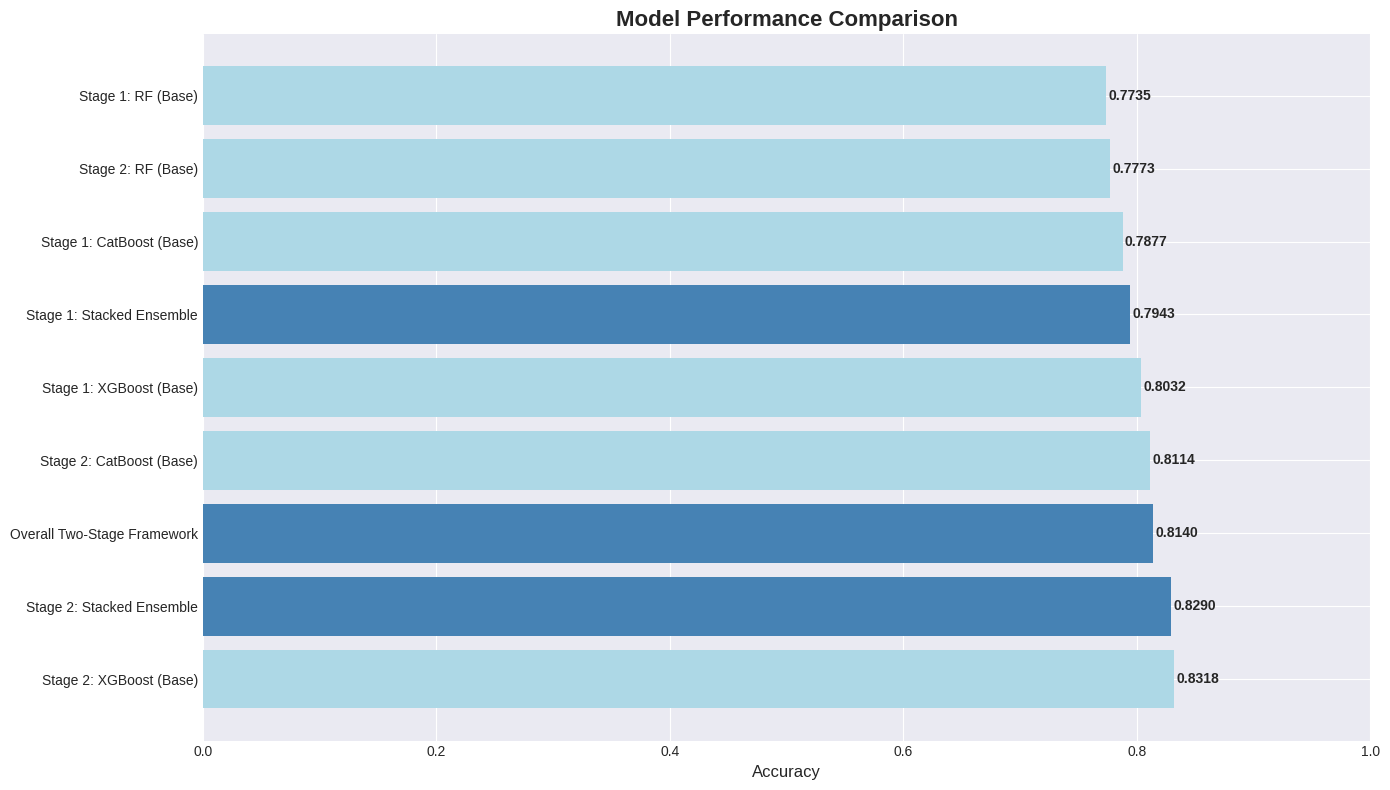

✅ Model comparison plotted!


In [47]:
# Visualize model comparison
plt.figure(figsize=(14, 8))
colors = ['steelblue' if 'Stacked' in model or 'Overall' in model else 'lightblue'
          for model in results_df['Model']]
bars = plt.barh(results_df['Model'], results_df['Accuracy'], color=colors)
plt.xlabel('Accuracy', fontsize=12)
plt.title('Model Performance Comparison', fontsize=16, fontweight='bold')
plt.xlim(0, 1.0)

# Add value labels
for i, (bar, acc) in enumerate(zip(bars, results_df['Accuracy'])):
    plt.text(acc + 0.002, bar.get_y() + bar.get_height()/2,
             f'{acc:.4f}', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Model comparison plotted!")

## 11. Summary and Conclusions

In [50]:
print("\n" + "="*80)
print("EXPERIMENT SUMMARY")
print("="*80)

print("\n1. DATASET:")
print(f"   - Name: NSL-KDD")
print(f"   - Training samples: {len(train_df)}")
print(f"   - Test samples: {len(test_df)}")
print(f"   - Original features: {len(feature_cols)}")
print(f"   - Selected features (MI-Boruta): {len(selected_features)}")

print("\n2. NOVEL CONTRIBUTIONS:")
print("   ✓ Two-stage hierarchical classification framework")
print("   ✓ Hybrid feature selection (Mutual Information + Boruta)")
print("   ✓ Stacked ensemble learning (RF + XGBoost + CatBoost + MLP)")
print("   ✓ SMOTE-based class imbalance handling")

print("\n3. KEY RESULTS:")
print(f"   Stage 1 (Binary):      {stage1_final_acc:.4f} ({stage1_final_acc*100:.2f}%)")
print(f"   Stage 2 (Multi-class): {stage2_final_acc:.4f} ({stage2_final_acc*100:.2f}%)")
print(f"   Overall Accuracy:      {overall_acc:.4f} ({overall_acc*100:.2f}%)")
print(f"   Overall F1-Score:      {overall_f1:.4f}")

print("\n4. PERFORMANCE COMPARISON:")
print(f"   Best base model (Stage 1): {max(rf_stage1_acc, xgb_stage1_acc, cat_stage1_acc):.4f}")
print(f"   Stacked ensemble (Stage 1): {stage1_final_acc:.4f}")
improvement_stage1 = (stage1_final_acc - max(rf_stage1_acc, xgb_stage1_acc, cat_stage1_acc)) * 100
print(f"   Improvement: +{improvement_stage1:.2f}%")

print("\n5. SAVED OUTPUTS:")
print("   ✓ class_distribution.png")
print("   ✓ mi_feature_importance.png")
print("   ✓ confusion_matrix_stage1.png")
print("   ✓ confusion_matrix_stage2.png")
print("   ✓ confusion_matrix_overall.png")
print("   ✓ model_comparison.png")

print("\n" + "="*80)
print("EXPERIMENT COMPLETED SUCCESSFULLY!")
print("="*80)


EXPERIMENT SUMMARY

1. DATASET:
   - Name: NSL-KDD
   - Training samples: 125973
   - Test samples: 22544
   - Original features: 41
   - Selected features (MI-Boruta): 33

2. NOVEL CONTRIBUTIONS:
   ✓ Two-stage hierarchical classification framework
   ✓ Hybrid feature selection (Mutual Information + Boruta)
   ✓ Stacked ensemble learning (RF + XGBoost + CatBoost + MLP)
   ✓ SMOTE-based class imbalance handling

3. KEY RESULTS:
   Stage 1 (Binary):      0.7943 (79.43%)
   Stage 2 (Multi-class): 0.8290 (82.90%)
   Overall Accuracy:      0.8140 (81.40%)
   Overall F1-Score:      0.8174

4. PERFORMANCE COMPARISON:
   Best base model (Stage 1): 0.8032
   Stacked ensemble (Stage 1): 0.7943
   Improvement: +-0.90%

5. SAVED OUTPUTS:
   ✓ class_distribution.png
   ✓ mi_feature_importance.png
   ✓ confusion_matrix_stage1.png
   ✓ confusion_matrix_stage2.png
   ✓ confusion_matrix_overall.png
   ✓ model_comparison.png

EXPERIMENT COMPLETED SUCCESSFULLY!


In [56]:
# Save results to CSV for paper writing

# Calculate overall precision and recall if not exists
if 'overall_precision' not in locals() or 'overall_recall' not in locals():
    attack_proportion = np.sum(y_test_binary == 1) / len(y_test_binary)
    benign_proportion = 1 - attack_proportion

    overall_precision = (stage1_final_precision * benign_proportion) + (stage2_final_precision * attack_proportion)
    overall_recall = (stage1_final_recall * benign_proportion) + (stage2_final_recall * attack_proportion)

    print("✓ Overall precision and recall calculated")

results_for_paper = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Stage 1 (Binary)': [stage1_final_acc, stage1_final_precision, stage1_final_recall, stage1_final_f1],
    'Stage 2 (Multi-class)': [stage2_final_acc, stage2_final_precision, stage2_final_recall, stage2_final_f1],
    'Overall Framework': [overall_acc, overall_precision, overall_recall, overall_f1]
}

results_paper_df = pd.DataFrame(results_for_paper)
results_paper_df.to_csv('results_for_paper.csv', index=False)

print("\nResults saved to 'results_for_paper.csv'")
print("\nResults Table:")
print(results_paper_df.to_string(index=False))

print("\nAll results saved!")


Results saved to 'results_for_paper.csv'

Results Table:
   Metric  Stage 1 (Binary)  Stage 2 (Multi-class)  Overall Framework
 Accuracy          0.794269               0.828957           0.814015
Precision          0.845555               0.878857           0.864512
   Recall          0.794269               0.828957           0.814015
 F1-Score          0.792696               0.836104           0.817406

All results saved!
